#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1 ]) # [Nm2] p. 4721 in [3]  

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.43290577, -0.06426251,  0.89914566],
       [-0.76250641,  0.50591652,  0.40327714],
       [-0.48080825, -0.86018533,  0.17001361]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001483


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
#     ans=np.einsum('ijk,ik->ij', Ret, B.T)  # here new
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000158


In [37]:
C1(dx,dy,dz,Ret)

array([[ 1.39274791e+00, -7.77539943e-02, -3.53721635e+00,
        -1.96381323e+00,  6.76442472e-01,  3.53817803e+00,
         3.05025615e-03, -8.75053187e-01,  1.35525412e+00,
         3.00015365e-01, -6.23854337e-01, -2.16702071e+00,
         2.28340091e-01,  6.99407617e-02,  4.89253745e-01,
         4.85779135e-02, -7.34093866e-01,  5.73773217e-01,
        -2.98399933e+00, -1.78211682e-01],
       [-2.51615604e+00,  7.54674116e-02,  1.14078657e-01,
         1.14361890e+01,  2.60168844e-02,  1.91526662e-01,
        -3.89822830e-01, -3.68809495e-01,  4.40169869e-02,
         1.36732056e+00, -2.33844923e-01, -2.95938139e+00,
         1.77581108e+00, -1.24900927e+00, -5.70834354e+00,
        -1.35663028e-01, -3.63163546e+00, -1.03411559e+00,
         2.88410451e-02,  4.94801420e-01],
       [ 1.83869732e+00, -6.40707652e-01, -1.48429925e+00,
        -1.14235785e+00,  3.20482472e-01,  2.07425785e-01,
        -4.52467552e-01, -1.97641788e-01, -1.41996292e-01,
         5.18698925e+00,  8.4

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 7.99302753e+03, -1.44403049e+04,  1.05523463e+04],
       [-4.46232812e+02,  4.33110036e+02, -3.67704296e+03],
       [-2.03002047e+04,  6.54701284e+02, -8.51844379e+03],
       [-1.12703908e+04,  6.56326769e+04, -6.55603047e+03],
       [ 3.88212630e+03,  1.49311783e+02,  1.83925978e+03],
       [ 2.03057238e+04,  1.09917801e+03,  1.19042362e+03],
       [ 1.75055236e+01, -2.23720645e+03, -2.59672664e+03],
       [-5.02195993e+03, -2.11661021e+03, -1.13427293e+03],
       [ 7.77784938e+03,  2.52614982e+02, -8.14921542e+02],
       [ 1.72179836e+03,  7.84709911e+03,  2.97683073e+04],
       [-3.58032121e+03, -1.34204395e+03,  4.87597796e+02],
       [-1.24366054e+04, -1.69839902e+04,  3.23383904e+04],
       [ 1.31045153e+03,  1.01914401e+04, -7.82818087e+03],
       [ 4.01392405e+02, -7.16810659e+03, -9.05504244e+02],
       [ 2.80784385e+03, -3.27603773e+04,  1.07399265e+04],
       [ 2.78790294e+02, -7.78574722e+02,  3.16981214e+03],
       [-4.21298961e+03, -2.08420791e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000238


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000173


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
# x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)
x,y,z=np.array([0.1*i for i in range(node_N)]),rng.standard_normal(node_N),np.array([0.01*i for i in range(node_N)])

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000026


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here new
    B=np.vstack([x,y,z])
#     dx_dt = np.gradient(B[0, :])
#     dy_dt = np.gradient(B[1, :])
#     dz_dt = np.gradient(B[2, :])
#     velocity = np.array([ [dx_dt[i], dy_dt[i], dz_dt[i]] for i in range(dx_dt.size)])
#     ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt+ dz_dt * dz_dt)
#     tangent = np.array([1/ds_dt] * 3).transpose() * velocity
#     return tangent
#     return B.T    
    return np.linalg.solve(Ret.astype(np.float64), B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.02178326,  0.00444406, -0.05563372],
       [-0.90528816,  0.61115571,  0.59075953],
       [-0.78688916,  1.31315495,  1.44040528],
       [ 0.26863452, -0.22084122,  0.69873054],
       [ 0.28939798, -0.26704552, -1.01724544],
       [ 0.49173455, -0.08178126,  0.21187788],
       [ 0.60863607, -0.05832759, -1.1060383 ],
       [ 1.11857561,  0.40039458, -0.07774912],
       [ 0.81552961,  0.05067067,  0.561669  ],
       [ 0.60363863, -0.63606385,  0.59166928],
       [-0.68143816,  1.3748797 , -0.59177761],
       [ 0.65124352, -1.90024243, -0.34821843],
       [ 0.84606838, -0.98618228, -0.05826441],
       [ 1.40829151, -0.42916832,  0.37823065],
       [ 1.21111878, -0.3420612 , -1.17062413],
       [-0.30346662,  1.80780114,  1.45621761],
       [ 0.81302227, -1.36280699,  0.70978381],
       [-1.49148864, -0.29390505, -0.95512058],
       [ 0.75932729,  2.53837913, -0.37328457],
       [ 0.72997532, -1.84082991,  0.21416186]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000090


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000370


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000336


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.34457927e+00,  1.29234204e+00,  2.05166322e-01],
       [-9.62775243e-01,  9.86693077e-01,  2.40405585e-01],
       [ 2.13894674e+00,  1.41978264e-01,  1.20023868e+00],
       [ 3.33872705e-01,  1.15221550e+00, -7.97808794e-01],
       [ 1.37674358e+00, -1.09808386e+00,  5.21626725e-01],
       [-1.00977056e+00,  4.06536459e-01,  2.89404718e-01],
       [-1.40322802e+00,  2.85783743e-02, -7.48422349e-01],
       [-2.28624748e-01, -1.93562631e-01, -1.25903111e+00],
       [-1.67209271e+00, -2.34775574e-01,  1.60449641e-01],
       [ 1.02919164e+00, -3.99356089e-01,  2.12157959e-01],
       [ 5.60842545e-01, -1.56297558e+00, -3.69020120e-01],
       [-3.52700599e-01,  3.24733892e-01,  2.89259612e-01],
       [ 3.07039537e-01, -5.39163137e-01,  5.01294595e-01],
       [-1.15160977e+00,  2.46606339e-01, -3.01031426e-01],
       [ 1.26781028e+00, -1.43087484e+00,  3.86489275e-01],
       [ 9.88768268e-04,  1.67642842e+00, -1.10592600e-02],
       [-8.01379474e-01,  9.39655789e-01

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T
#     return np.einsum('ijk,ij->ik',K, fun).T   # here new

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.1 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-0.00043865, -0.06018622, -0.1293158 ,  0.0217635 ,  0.02628583,
         0.00805861,  0.00572658, -0.03943834, -0.00498147,  0.06265926,
        -0.13542926,  0.18715945,  0.0971335 ,  0.04227743,  0.03367197,
        -0.17803594,  0.13424212,  0.0289324 , -0.25002503,  0.18131695],
       [ 0.0034729 , -0.14882757, -0.22297152, -0.04410551,  0.13123599,
         0.02703608,  0.17164668,  0.1180265 ,  0.02360302, -0.00029701,
        -0.00735495,  0.0993111 ,  0.08921801,  0.10051281,  0.23751102,
        -0.17695348,  0.00839794, -0.05044724,  0.11248829,  0.05027105],
       [ 0.00044917,  0.06173569,  0.13262861, -0.02230723, -0.02697374,
        -0.00826728, -0.00590064,  0.04041721,  0.00510364, -0.06424614,
         0.13886044, -0.19191631, -0.09960863, -0.04336516, -0.03456493,
         0.18257487, -0.1376434 , -0.02965662,  0.25633823, -0.18591755]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000711


In [67]:
def ne(x,y,z,Ret,omega,force): # here new

    A=np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',Ret, CT), np.transpose(Ret,(0,2,1)))
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([0,0,0]).reshape(3,1)).squeeze()
                    ) 

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 0.00059908, -0.01235757,  0.02094599,  0.0072656 , -0.00995231,
         0.00224736,  0.01138938,  0.00999619, -0.00518987,  0.00613919,
        -0.01208254,  0.0180018 ,  0.00593091, -0.00642862,  0.01113416,
        -0.01626953, -0.00490924,  0.00711521, -0.01779885,  0.00736991],
       [ 0.        ,  0.00133347, -0.00280278, -0.00012688,  0.00562762,
         0.00337582, -0.00337523, -0.0024709 ,  0.01091564,  0.00221675,
         0.01267474, -0.01287061,  0.00439728,  0.01837948, -0.00429861,
         0.01148515,  0.02245913,  0.00587017,  0.00901681,  0.00667374],
       [-0.00059911,  0.01237141, -0.02097482, -0.00726723,  0.01000855,
        -0.00221406, -0.01142339, -0.01002118,  0.00529821, -0.00611757,
         0.01220865, -0.01813016, -0.00588768,  0.00661092, -0.01117729,
         0.01638408,  0.00513184, -0.00705747,  0.01788904, -0.00730422]])

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-7.99302753e+03,  4.46232812e+02,  2.03002047e+04,
         1.12703908e+04, -3.88212630e+03, -2.03057238e+04,
        -1.75055236e+01,  5.02195993e+03, -7.77784938e+03,
        -1.72179836e+03,  3.58032121e+03,  1.24366054e+04,
        -1.31045153e+03, -4.01392405e+02, -2.80784385e+03,
        -2.78790294e+02,  4.21298961e+03, -3.29290397e+03,
         1.71252734e+04,  1.02276289e+03],
       [ 1.44403049e+04, -4.33110036e+02, -6.54701284e+02,
        -6.56326769e+04, -1.49311783e+02, -1.09917801e+03,
         2.23720645e+03,  2.11661021e+03, -2.52614982e+02,
        -7.84709911e+03,  1.34204395e+03,  1.69839902e+04,
        -1.01914401e+04,  7.16810659e+03,  3.27603773e+04,
         7.78574722e+02,  2.08420791e+04,  5.93482449e+03,
        -1.65519737e+02, -2.83968214e+03],
       [-1.06805109e+04,  3.54887842e+03,  8.39027925e+03,
         6.42786593e+03, -1.96742432e+03, -1.31858816e+03,
         2.46856210e+03,  1.00610838e+03,  6.86756999e+02,
        -2.98964719e+04, -6.1

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000999


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[  -3389.17645484,    -812.1296406 ,    3381.31234128],
       [ 148996.42005701, -121913.62165195, -150211.15428778],
       [ 221421.92470821, -263264.75496633, -224039.84925496],
       [  43224.84477347,   43208.39575979,  -42799.31482671],
       [-130394.76969524,   54126.93927556,  130937.42551535],
       [ -27905.56795959,   15658.87943736,   28062.04731312],
       [-171403.92097076,   12157.29725748,  171533.19570426],
       [-120028.02170869,  -81105.31794068,  119231.29334686],
       [ -25438.70627836,  -11497.00348103,   25326.20492339],
       [   -569.95928749,  126023.10476288,    1817.66029075],
       [   7607.63280137, -273701.75943431,  -10317.76841218],
       [ -98062.98381243,  379729.47711613,  101827.53356782],
       [ -89456.34510827,  196446.67726546,   91405.88558621],
       [-102582.545149  ,   84060.76363289,  103420.10965883],
       [-237829.3196246 ,   68368.66986025,  238518.56022611],
       [ 174171.32588972, -362683.28124096, -177771.070

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[   -38930.72842029,    338516.30335165,     42284.17880866],
       [ -6169729.61379629, -14960021.17461887,   6021941.18340423],
       [-13273477.49394997, -22272557.43910809,  13053661.89150833],
       [  2139126.43169431,  -4301104.17693881,  -2181820.05713222],
       [  2771024.63282273,  13066296.80386792,  -2641807.97416163],
       [   796795.31442022,   2798313.79232494,   -769132.49645182],
       [   692742.05372342,  17146444.39397256,   -523022.47858535],
       [ -3996044.55954114,  11962677.54774814,   4114686.91665734],
       [  -562285.15600957,   2538184.48361352,    587443.28098833],
       [  6301739.87867195,    119379.73518672,  -6300885.6831594 ],
       [-13689510.8681423 ,   -896252.06898998,  13681349.553987  ],
       [ 19035928.27453004,   9994290.84571701, -18937971.32448745],
       [  9867087.89757492,   9042896.99050064,  -9778073.26876796],
       [  4254020.15357692,  10299886.57599598,  -4152269.0109106 ],
       [  3536327.37258094,  23816

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000302


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
       
        return np.einsum('ijk,ik->ik',  np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',Ret, CR),
                                                  np.transpose(Ret,(0,2,1))),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000621


In [82]:
d_me_

array([[ 0.00000000e+00,  2.73824008e-09,  0.00000000e+00],
       [-1.45519152e-11, -1.50859324e-09,  0.00000000e+00],
       [-1.45519152e-11, -2.17914430e-09, -1.45519152e-11],
       [ 0.00000000e+00, -2.03013627e-09, -2.91038305e-11],
       [-1.45519152e-11, -9.87050215e-10, -1.45519152e-11],
       [-1.45519152e-11, -3.16499154e-10,  1.45519152e-11],
       [-1.45519152e-11,  1.54614600e-09,  2.91038305e-11],
       [-1.45519152e-11, -2.03013627e-09,  0.00000000e+00],
       [ 0.00000000e+00,  3.40879114e-09,  2.91038305e-11],
       [ 0.00000000e+00,  2.73824008e-09,  1.45519152e-11],
       [ 1.45519152e-11,  3.54051908e-10, -1.45519152e-11],
       [-1.45519152e-11, -1.50859324e-09,  0.00000000e+00],
       [ 1.45519152e-11,  3.93033417e-09,  1.45519152e-11],
       [-1.45519152e-11,  1.54614600e-09,  1.45519152e-11],
       [ 2.91038305e-11, -3.16499154e-10, -1.45519152e-11],
       [-1.45519152e-11,  2.73824008e-09,  1.45519152e-11],
       [ 2.91038305e-11,  1.39713796e-09

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-7.99302753e+03,  4.46232812e+02,  2.03002047e+04,
         1.12703908e+04, -3.88212630e+03, -2.03057238e+04,
        -1.75055236e+01,  5.02195993e+03, -7.77784938e+03,
        -1.72179836e+03,  3.58032121e+03,  1.24366054e+04,
        -1.31045153e+03, -4.01392405e+02, -2.80784385e+03,
        -2.78790294e+02,  4.21298961e+03, -3.29290397e+03,
         1.71252734e+04,  1.02276289e+03],
       [ 1.44403049e+04, -4.33110036e+02, -6.54701284e+02,
        -6.56326769e+04, -1.49311783e+02, -1.09917801e+03,
         2.23720645e+03,  2.11661021e+03, -2.52614982e+02,
        -7.84709911e+03,  1.34204395e+03,  1.69839902e+04,
        -1.01914401e+04,  7.16810659e+03,  3.27603773e+04,
         7.78574722e+02,  2.08420791e+04,  5.93482449e+03,
        -1.65519737e+02, -2.83968214e+03],
       [-1.06805109e+04,  3.54887842e+03,  8.39027925e+03,
         6.42786593e+03, -1.96742432e+03, -1.31858816e+03,
         2.46856210e+03,  1.00610838e+03,  6.86756999e+02,
        -2.98964719e+04, -6.1

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=100

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

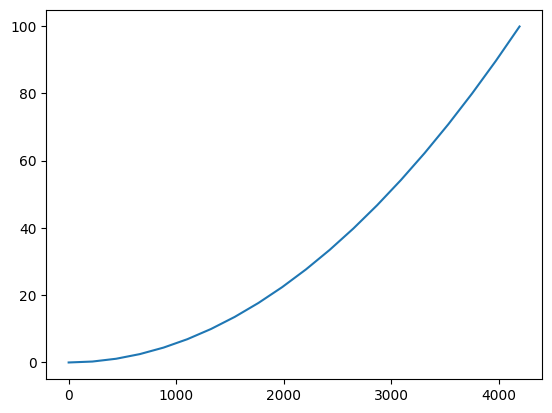

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

#     return np.array(ans[::-1])
    return np.array(ans) # here new

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 2.20749435e+02, 4.41498870e+02, 6.62248306e+02,
       8.82997741e+02, 1.10374718e+03, 1.32449661e+03, 1.54524605e+03,
       1.76599548e+03, 1.98674492e+03, 2.20749435e+03, 2.42824379e+03,
       2.64899322e+03, 2.86974266e+03, 3.09049209e+03, 3.31124153e+03,
       3.53199096e+03, 3.75274040e+03, 3.97348983e+03, 4.19423927e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  2.207e+02 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ...  1.182e-31 -5.897e-31]
           [ 0.000e+00  0.000e+00 ...  1.168e-08  1.326e-08]
           ...
           [ 0.000e+00  0.000e+00 ... -2.999e-06 -7.199e-07]
           [ 0.000e+00  0.000e+00 ... -2.827e-06 -9.894e-07]]
       r: [-4.272e+03 -4.272e+03 ...  0.000e+00  0.000e+00]
     qtf: [ 1.464e+01  7.082e+04 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
# x0_=x0_-x0_[-1]
# z0_=z0_-z0_[-1]

In [106]:
q0=root_.x
# for j in range(1,12):
#     if j==1:
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:
#         q0[(j-1)*node_N:j*node_N]=z0_

In [107]:
q0

array([0.00000000e+00, 2.20749435e+02, 4.41498870e+02, 6.62248306e+02,
       8.82997741e+02, 1.10374718e+03, 1.32449661e+03, 1.54524605e+03,
       1.76599548e+03, 1.98674492e+03, 2.20749435e+03, 2.42824379e+03,
       2.64899322e+03, 2.86974266e+03, 3.09049209e+03, 3.31124153e+03,
       3.53199096e+03, 3.75274040e+03, 3.97348983e+03, 4.19423927e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

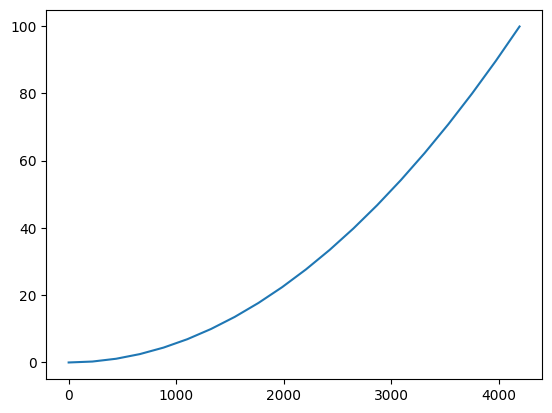

In [108]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [109]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [110]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [111]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [112]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [113]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [114]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [115]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [116]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [119]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.16415322e-09,  9.36807965e-08,  8.16035026e-08],
       [ 2.63564289e-07, -8.80238531e-08, -4.89089871e-08],
       [-3.46451998e-07,  4.06626768e-08, -1.13650458e-07],
       [ 3.70666385e-07,  2.06493496e-07, -1.42026693e-07],
       [ 2.38418579e-07, -3.93501978e-07,  1.93598680e-07],
       [-6.25848770e-07, -3.66308086e-08,  2.69850716e-07],
       [ 3.65078449e-07, -6.00563037e-08,  3.26079316e-07],
       [-4.02331352e-07,  2.41558155e-07, -5.63450158e-08],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08

### Vessle Simulation

In [120]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [121]:
N*sampleTime

100.0

In [122]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [123]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [124]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

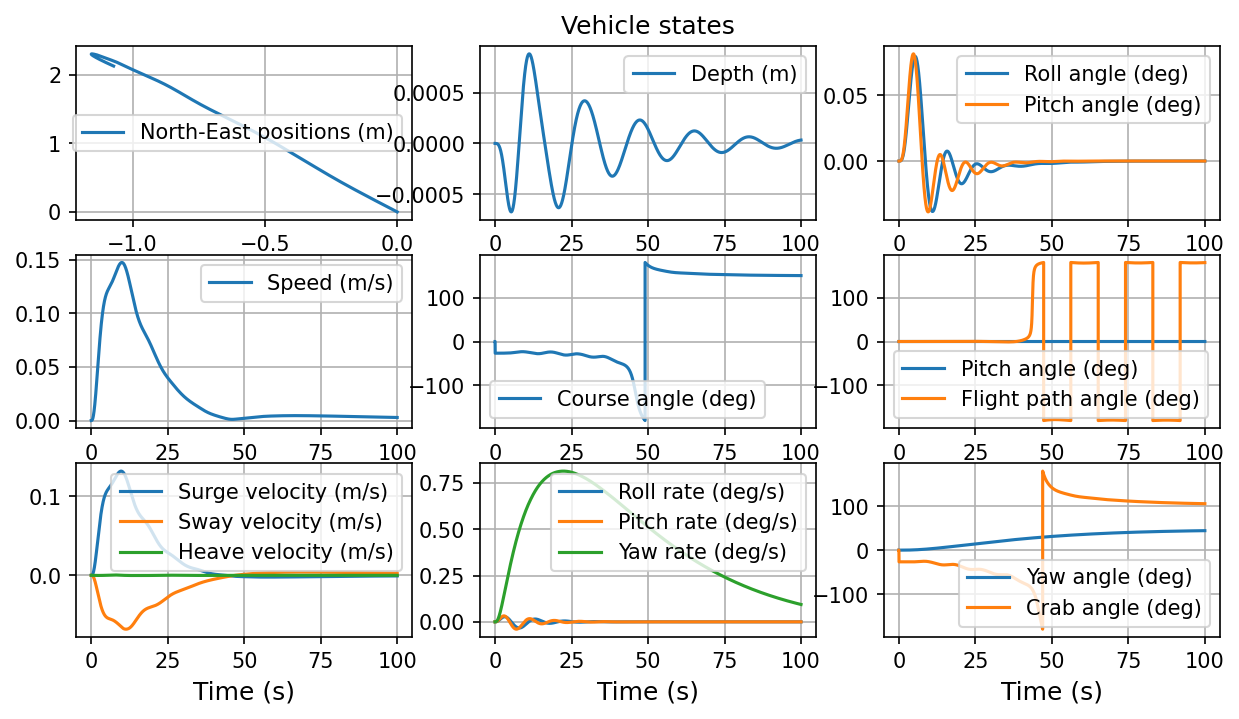

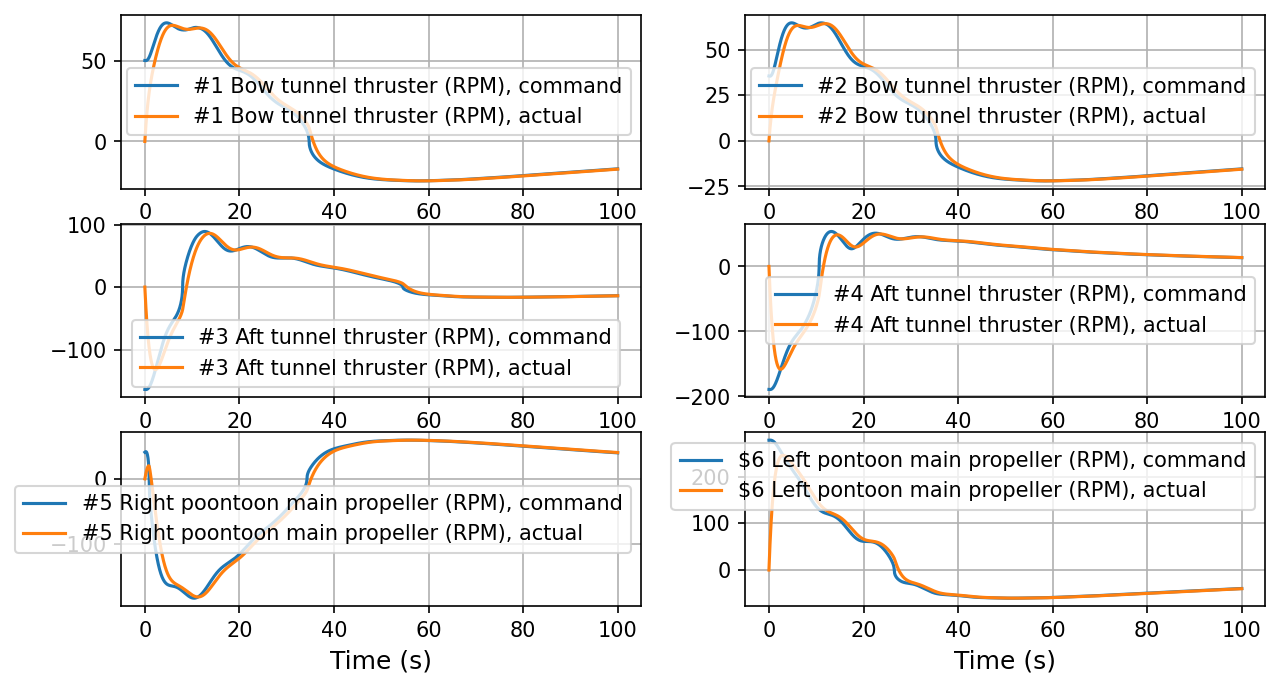

In [125]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [126]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

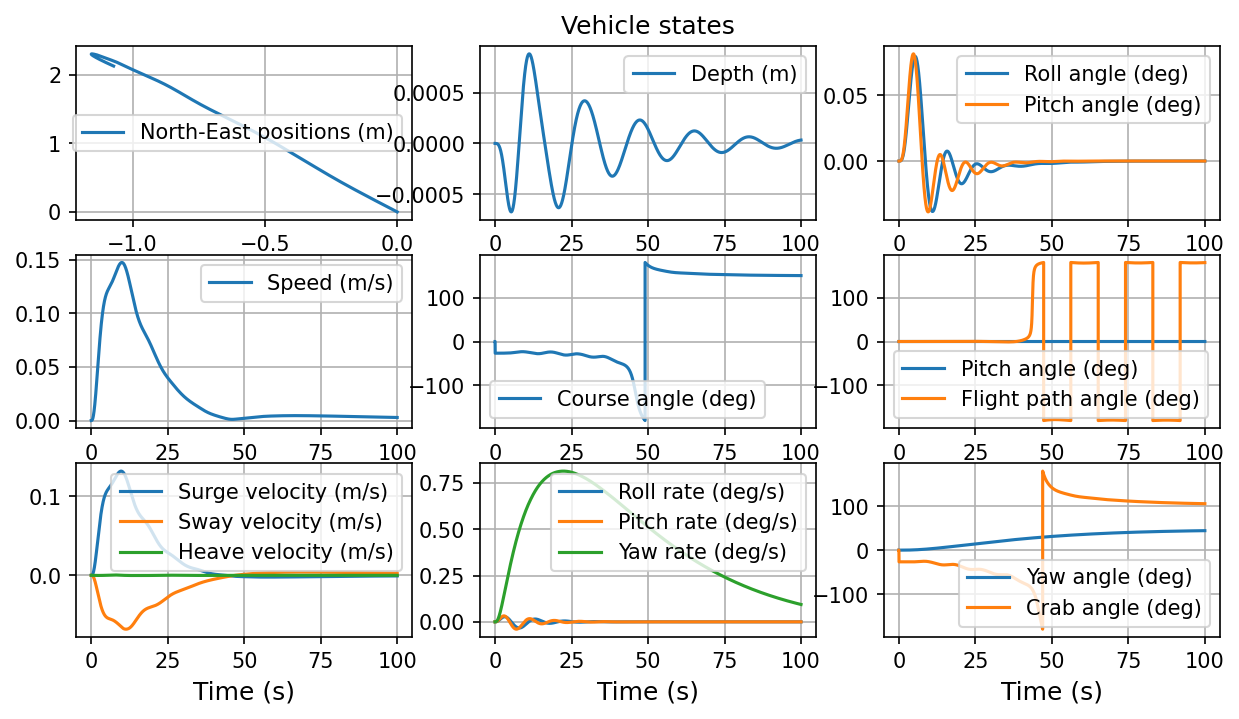

In [127]:
plotVehicleStates(simTime, simData, 3)

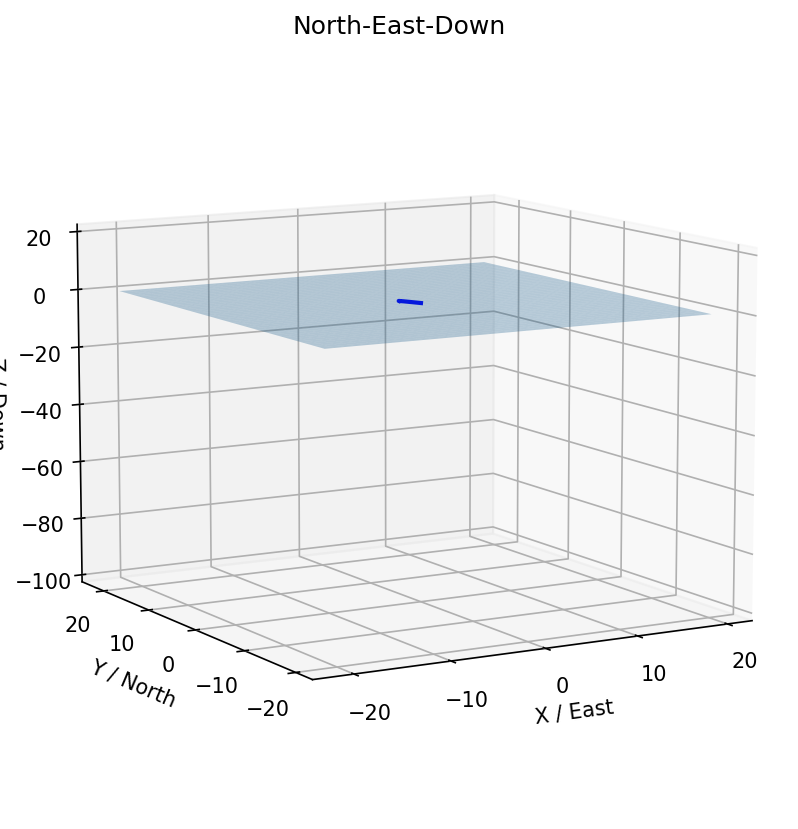

In [128]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [129]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [130]:
idx=1/0.01

In [131]:
idx

100.0

In [132]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [133]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [134]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [135]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
#     return np.array(ans[::-1])
    return np.array(ans)  # here new

In [136]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [137]:
M_t

array([3150635.90893617, 3151577.66893617, 3152519.42893617,
       3153461.18893617, 3154402.94893617, 3155344.70893617,
       3156286.46893617, 3157228.22893617, 3158169.98893617,
       3159111.74893617, 3160053.50893617, 3160995.26893617,
       3161937.02893617, 3162878.78893617, 3163820.54893617,
       3164762.30893617, 3165704.06893617, 3166645.82893617,
       3167587.58893617, 3168529.34893617])

### Dynamics

In [138]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.vx=0
        self.vy=0
        self.vz=0

In [492]:
# key takeaways: 
# initial condition affect the solution
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000236 for i in range(node_N)])

In [493]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
#     print(vessel_movement)
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     print(fors[0])

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0=  -np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=  d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T # here new
#     print(Z1)
#     Z1=np.gradient(ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))[0]
#     print(Z1)
    Z2=  ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
    
#     ddx[-1]=(u_ve-T.vx)/(del_t+1e-7)
#     ddy[-1]=(v_ve-T.vy)/(del_t+1e-7)
#     ddz[-1]=(w_ve-T.vz)/(del_t+1e-7)
#     print(ddx)

#     ddx,ddy, ddz = (Z/M_t[:,None]).T # here new


    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T 

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
    T.vx=u_ve
    T.vy=v_ve
    T.vz=-w_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [494]:
tspan = (0., 100)
T_ = MyTime()

In [495]:
coefs = [1, 1, 1, 1, 1, 1]

In [496]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  2.505225478343665e-05  Iteration wall clock time:  0:00:01.288506
Physical time:  1.1728661478382225  Iteration wall clock time:  0:00:07.232739
Physical time:  2.4236694734325646  Iteration wall clock time:  0:00:02.134360
Physical time:  3.27782486128495  Iteration wall clock time:  0:00:04.267917
Physical time:  4.00354577491313  Iteration wall clock time:  0:00:04.084942
Physical time:  5.055534629410441  Iteration wall clock time:  0:00:03.700118
Physical time:  6.1262938711808905  Iteration wall clock time:  0:00:02.814146
Physical time:  7.023886379654001  Iteration wall clock time:  0:00:03.446177
Physical time:  8.027618515096382  Iteration wall clock time:  0:00:04.124902
Physical time:  9.005698782014738  Iteration wall clock time:  0:00:04.422863
Physical time:  10.039996551449276  Iteration wall clock time:  0:00:04.352885
Physical time:  11.015149122940391  Iteration wall clock time:  0:00:03.532441
Physical time:  12.301148190008627  Iteration wall clock 

### Results

In [497]:
fin=us

In [498]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.505e-03 ...  9.951e+01  1.000e+02]
        y: [[ 0.000e+00 -5.000e-20 ... -4.733e-03 -4.782e-03]
            [ 2.207e+02  2.207e+02 ...  2.207e+02  2.207e+02]
            ...
            [ 0.000e+00 -4.533e-26 ... -1.565e-17 -9.580e-18]
            [ 0.000e+00 -1.435e-24 ... -1.403e-07 -8.582e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 350
     njev: 0
      nlu: 0

In [499]:
t=fin.t

In [500]:
fin=fin.y.T

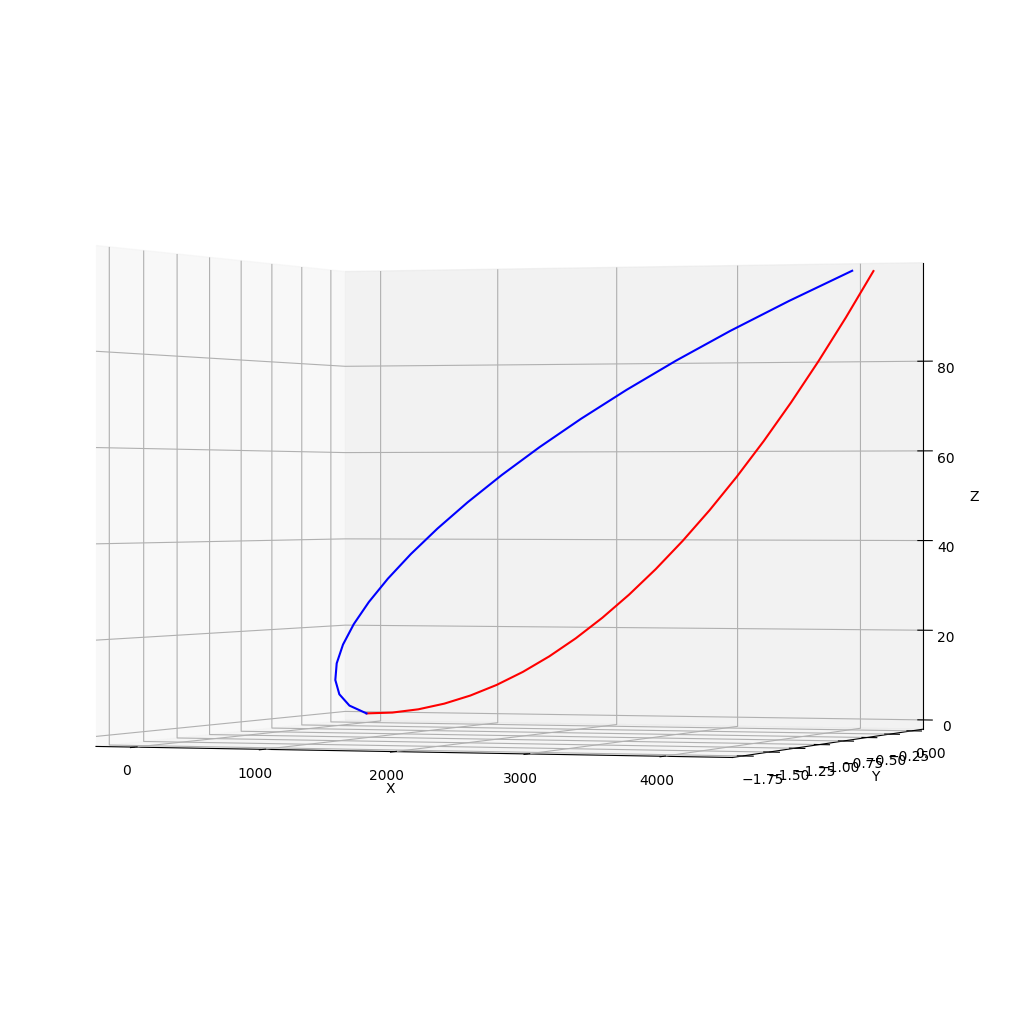

In [501]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-70)
plt.show()

In [502]:
X,Y,Z

(array([-4.78242368e-03,  2.20669306e+02,  4.41320754e+02,  6.61961728e+02,
         8.82602029e+02,  1.10324956e+03,  1.32391061e+03,  1.54459002e+03,
         1.76529134e+03,  1.98601686e+03,  2.20676768e+03,  2.42754373e+03,
         2.64834379e+03,  2.86916543e+03,  3.09000501e+03,  3.31085761e+03,
         3.53171688e+03,  3.75257494e+03,  3.97342203e+03,  4.19266920e+03]),
 array([ 1.04729205e-04, -3.75155572e-01, -6.85747814e-01, -9.43262065e-01,
        -1.15589956e+00, -1.32952396e+00, -1.46831601e+00, -1.57518994e+00,
        -1.65205886e+00, -1.69999882e+00, -1.71933957e+00, -1.70969682e+00,
        -1.66995119e+00, -1.59817182e+00, -1.49147343e+00, -1.34578545e+00,
        -1.15549481e+00, -9.12898047e-01, -6.07370323e-01, -2.33060086e-01]),
 array([-7.29679201e-04,  2.83661626e+00,  6.21739773e+00,  1.00131485e+01,
         1.41353336e+01,  1.85217011e+01,  2.31280472e+01,  2.79230954e+01,
         3.28852617e+01,  3.80006242e+01,  4.32617133e+01,  4.86669140e+01,
        

In [503]:
X0,Y0,Z0

(array([   0.        ,  220.74943519,  441.49887038,  662.24830556,
         882.99774075, 1103.74717594, 1324.49661113, 1545.24604631,
        1765.9954815 , 1986.74491669, 2207.49435188, 2428.24378706,
        2648.99322225, 2869.74265744, 3090.49209263, 3311.24152781,
        3531.990963  , 3752.74039819, 3973.48983338, 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.27664154,  1.10656789,  2.48978426,  4.42629935,
         6.91612533,  9.95927782, 13.55577595, 17.70564231, 22.40890298,
        27.66558749, 33.47572887, 39.83936361, 46.7565317 , 54.22727659,
        62.25164521, 70.82968796, 79.96145874, 89.64701491, 99.88641731]))

In [504]:
us=fin.T

In [505]:
us.shape

(240, 55)

In [506]:
12*50

600

In [507]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00, -6.75734316e-27, -8.09885513e-25, -3.78643545e-22,
       -5.22475723e-19,  2.25269031e-19,  2.35002453e-18, -1.14392116e-18,
       -9.89951350e-18, -9.59073936e-18, -8.62692684e-18, -8.71604106e-18,
       -9.04850875e-18, -9.61700987e-18, -9.26568659e-18, -9.03334606e-18,
       -8.84399322e-18, -8.53321965e-18, -7.44338505e-18, -5.92903828e-18,
       -6.52613080e-18, -1.41138454e-17, -1.43954938e-17, -2.39887392e-18,
        6.19529262e-18,  3.14215721e-17,  6.97901030e-17,  8.44528565e-17,
        5.07435061e-17,  2.18552431e-17,  5.75539520e-18, -1.53773593e-17,
       -4.57167349e-17, -1.10557579e-17, -3.77521820e-17, -4.69414885e-17,
       -3.21676256e-17, -8.08011438e-18, -1.34288686e-17, -4.34234189e-17,
       -5.19183749e-17, -5.40266517e-17, -4.99584010e-17, -4.89486993e-17,
       -5.26032540e-17, -5.45651029e-17, -4.83091045e-17, -3.56276494e-17,
       -2.27485270e-17, -3.05853735e-17, -4.71432911e-17, -5.45211294e-17,
       -5.01378487e-17, -

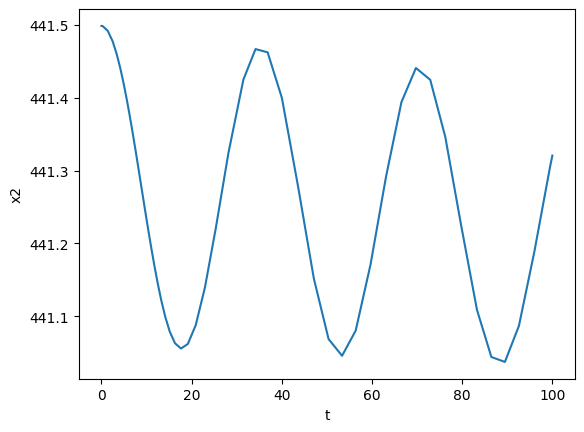

In [508]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

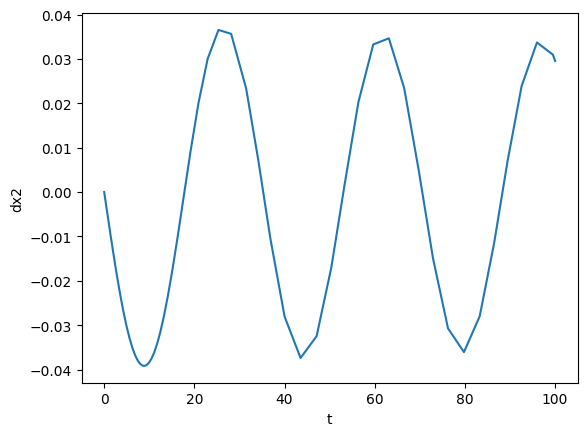

In [509]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

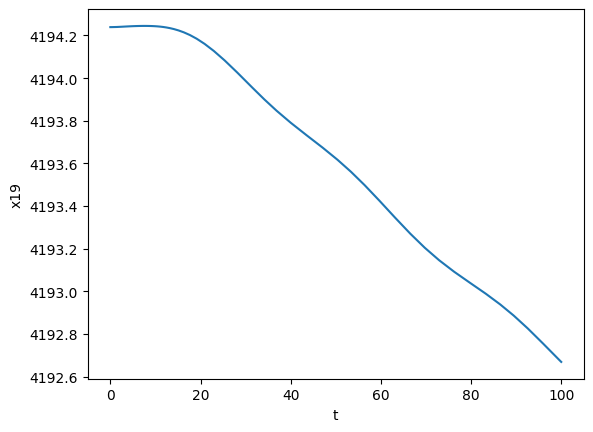

In [510]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

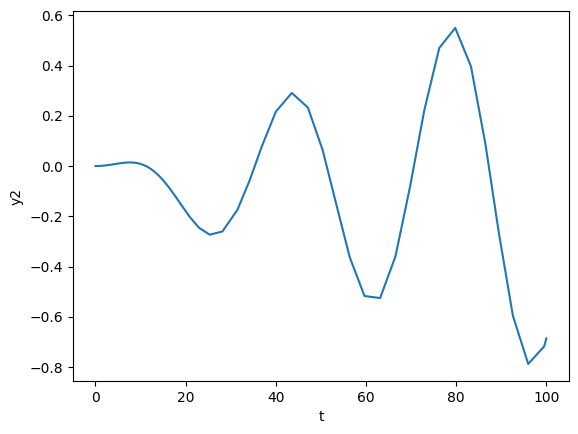

In [511]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

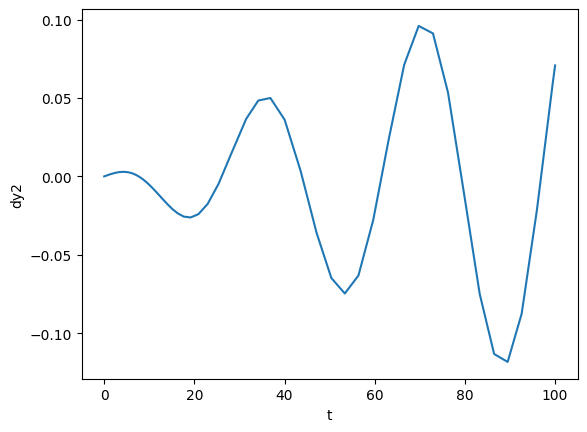

In [512]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

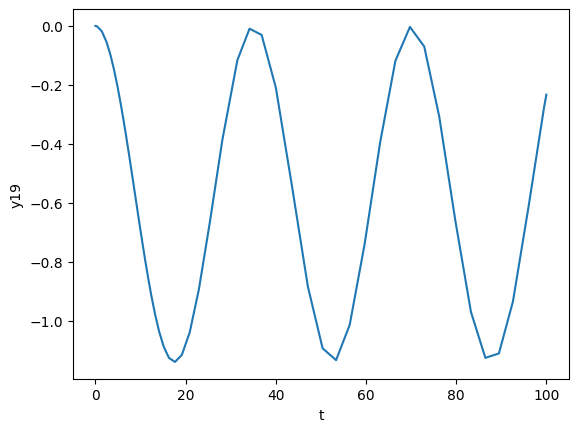

In [513]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

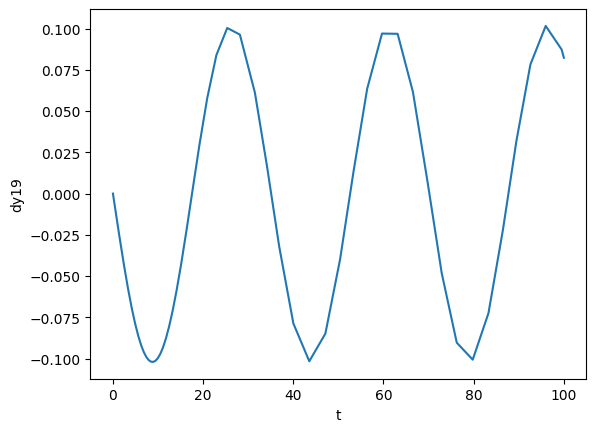

In [514]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

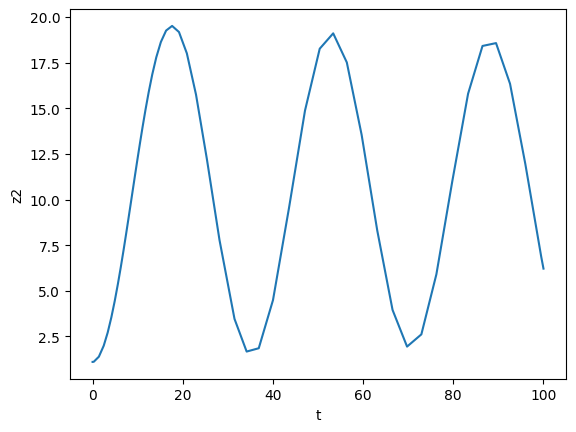

In [515]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

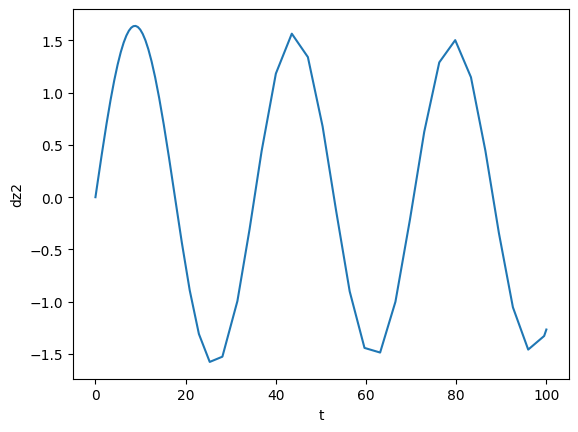

In [516]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

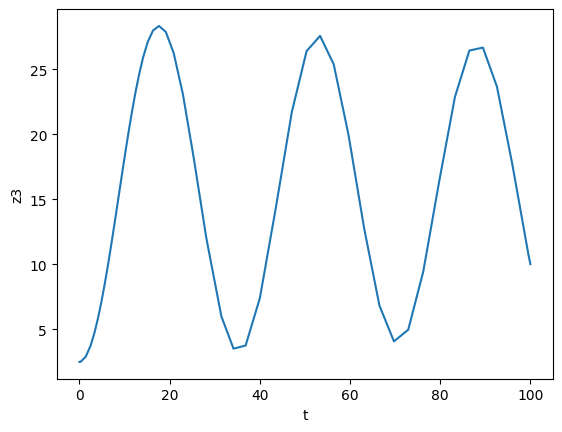

In [517]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

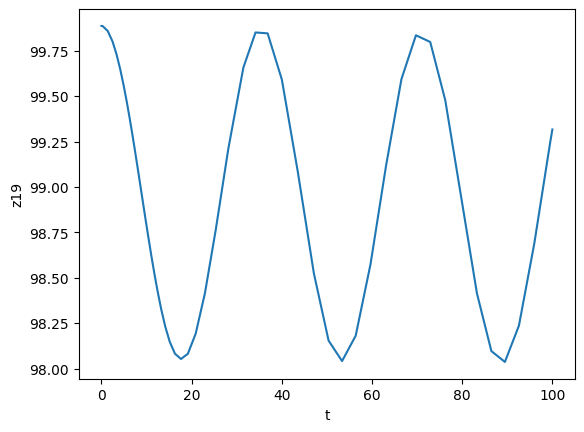

In [518]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

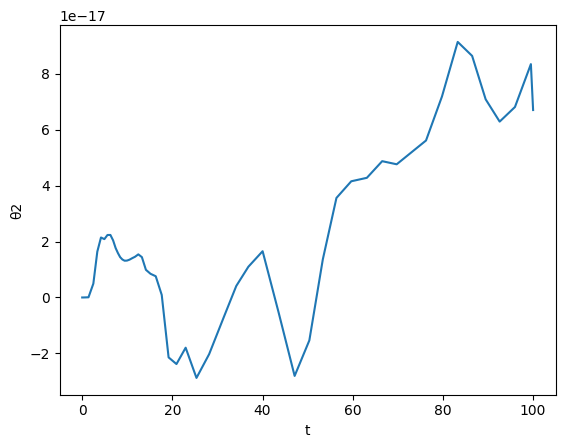

In [519]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

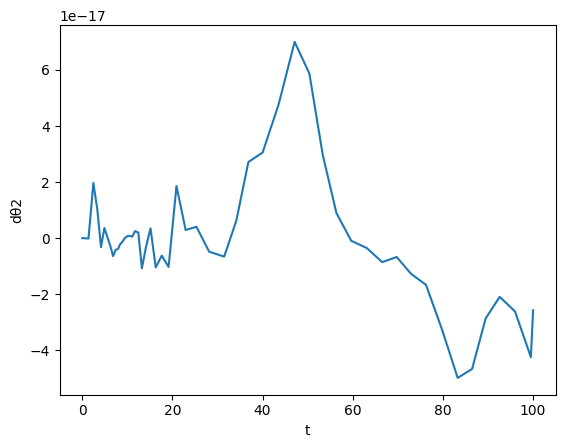

In [520]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

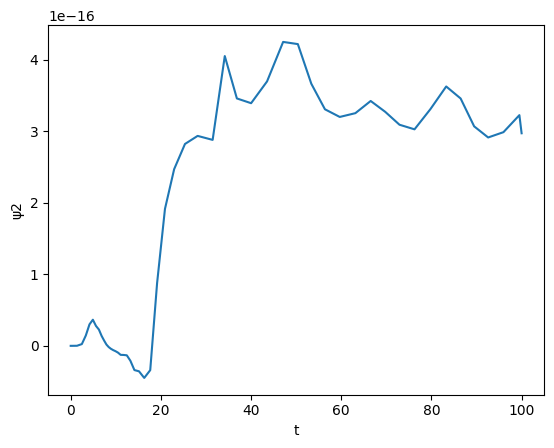

In [521]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

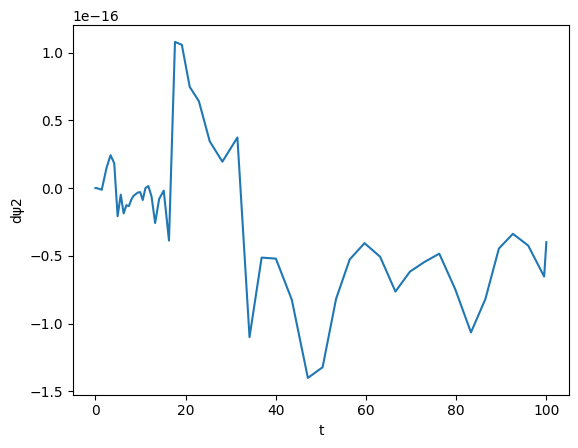

In [522]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

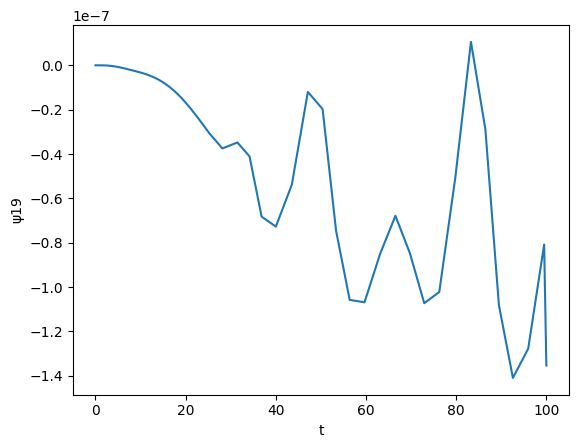

In [523]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()